In [229]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score
import shap

# Assumtions:
1. Job Description is the same in all rows, so I removed it.
2. I've filled in missing values in certifications with an empty string. 
3. Converted candidate skills and required skills to "No. of matching skills" and "Skills overlap ratio" columns
4. Converted Certifications and past job title with "No. of certifications" and "No. of past jobs" columns
5. Converted candidate experience and minimum experience required to "experience gap" --> +ve means over experience, -ve means under experience.
6. Converted salary columns with "if expected salary under budget" and "expected salary deviation from the mean of the budget" columns
7. Converted location columns with "is location match"
8. Used one hot encoding for location, education level as the categories are less
9. The data is highly imbalanced.
   1. Used a stratified split of train and test data.
   2. For Random Forest, I used SMOTE
   3. For XGBoost, I've provided a more weighted minority class.

## Data understanding

In [230]:
df = pd.read_csv('data.csv')

print("Columns:", df.columns)
df.head(3)  

Columns: Index(['candidate_skills', 'years_experience', 'education_level',
       'past_job_titles', 'certifications', 'expected_salary',
       'candidate_location', 'job_title', 'required_skills', 'min_experience',
       'job_description', 'budgeted_salary_min', 'budgeted_salary_max',
       'job_location', 'is_fit'],
      dtype='object')


,candidate_skills,years_experience,education_level,past_job_titles,certifications,expected_salary,candidate_location,job_title,required_skills,min_experience,job_description,budgeted_salary_min,budgeted_salary_max,job_location,is_fit
0,"Node.js, AWS, Python, SQL, NLP, Deep Learning",6,High School,"Backend Engineer, Software Developer",Google ML Certificate,129409,New York,AI Researcher,"Data Analysis, Deep Learning, React, Docker, Java",0,Looking for a motivated individual with strong...,81174,141383,Remote,0
1,"TensorFlow, React, Machine Learning",2,Master's,ML Engineer,Coursera NLP,113724,Austin,Backend Engineer,"Deep Learning, Pandas, Data Analysis, Java, NLP",1,Looking for a motivated individual with strong...,64098,115875,Remote,0
2,"Kubernetes, Python, Pandas, AWS",11,High School,"Backend Engineer, ML Engineer","AWS Certified, Coursera NLP",67692,New York,AI Researcher,"SQL, React, Java, Kubernetes, TensorFlow",6,Looking for a motivated individual with strong...,76658,105418,San Francisco,0


In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   candidate_skills     5000 non-null   object
 1   years_experience     5000 non-null   int64 
 2   education_level      5000 non-null   object
 3   past_job_titles      5000 non-null   object
 4   certifications       4475 non-null   object
 5   expected_salary      5000 non-null   int64 
 6   candidate_location   5000 non-null   object
 7   job_title            5000 non-null   object
 8   required_skills      5000 non-null   object
 9   min_experience       5000 non-null   int64 
 10  job_description      5000 non-null   object
 11  budgeted_salary_min  5000 non-null   int64 
 12  budgeted_salary_max  5000 non-null   int64 
 13  job_location         5000 non-null   object
 14  is_fit               5000 non-null   int64 
dtypes: int64(6), object(9)
memory usage: 586.1+ KB


In [232]:
df.describe()

,years_experience,expected_salary,min_experience,budgeted_salary_min,budgeted_salary_max,is_fit
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,6.049000,99628.256800,5.076000,79761.885800,130404.764000,0.038800
std,3.802669,28887.591416,3.164969,11471.314108,17298.181079,0.193137
min,0.000000,50004.000000,0.000000,60004.000000,100070.000000,0.000000
25%,3.000000,74454.750000,2.000000,69964.250000,115582.750000,0.000000
50%,6.000000,99489.000000,5.000000,79582.500000,130498.500000,0.000000
75%,10.000000,124877.250000,8.000000,89655.000000,145257.500000,0.000000
max,12.000000,149969.000000,10.000000,99990.000000,159995.000000,1.000000


In [233]:
df['is_fit'].value_counts()

is_fit
0    4806
1     194
Name: count, dtype: int64

In [234]:
df.isnull().sum()

candidate_skills         0
years_experience         0
education_level          0
past_job_titles          0
certifications         525
expected_salary          0
candidate_location       0
job_title                0
required_skills          0
min_experience           0
job_description          0
budgeted_salary_min      0
budgeted_salary_max      0
job_location             0
is_fit                   0
dtype: int64

In [235]:
temp = df['candidate_skills'].apply(lambda x: x.split(', '))
skills = set()
for i in temp:
    for j in i:
        skills.add(j)
print("Candidate Skills:", skills)
required_skills = set()
temp2 = df['required_skills'].apply(lambda x: x.split(', '))
for i in temp2:
    for j in i:
        required_skills.add(j)
print("\nRequired skills", required_skills)

Candidate Skills: {'AWS', 'Docker', 'TensorFlow', 'Java', 'Deep Learning', 'Kubernetes', 'Python', 'Machine Learning', 'Pandas', 'NLP', 'SQL', 'Data Analysis', 'React', 'Node.js'}

Required skills {'AWS', 'Docker', 'TensorFlow', 'Java', 'Deep Learning', 'Pandas', 'Kubernetes', 'Machine Learning', 'Python', 'NLP', 'SQL', 'Data Analysis', 'React', 'Node.js'}


In [236]:
temp3 = df['past_job_titles'].apply(lambda x: x.split(', '))
Job_titles = set()
for i in temp3:
    for j in i:
        Job_titles.add(j)
print("\nJob titles:", Job_titles)


Job titles: {'Backend Engineer', 'AI Researcher', 'Data Scientist', 'ML Engineer', 'Software Developer'}


In [237]:
temp4 = df['certifications'].apply(lambda x: x.split(', ') if x is not np.nan else "") 
cert = set()
for i in temp3:
    for j in i:
        cert.add(j)
print("\nCertifications:", Job_titles)


Certifications: {'Backend Engineer', 'AI Researcher', 'Data Scientist', 'ML Engineer', 'Software Developer'}


In [238]:
# Job Description is the same in all rows, so I removed it.
df['job_description'].unique()

array(['Looking for a motivated individual with strong technical and problem-solving skills.'],
      dtype=object)

## Data Preprocesing

In [239]:
# 1. Dropping Job description as it's same for all rows.
df.drop('job_description', axis=1, inplace=True)

In [240]:
# 2. Fill missing certifications with empty string
df['certifications'] = df['certifications'].fillna('')
df.isnull().sum()

candidate_skills       0
years_experience       0
education_level        0
past_job_titles        0
certifications         0
expected_salary        0
candidate_location     0
job_title              0
required_skills        0
min_experience         0
budgeted_salary_min    0
budgeted_salary_max    0
job_location           0
is_fit                 0
dtype: int64

In [241]:
# 3.1 Parse the string with comma
def parse_comma_col(x):
    return [i.strip().lower() for i in x.split(',') if i.strip()]

for col in ['candidate_skills', 'required_skills']:
    df[col] = df[col].apply(parse_comma_col)
df.head()

,candidate_skills,years_experience,education_level,past_job_titles,certifications,expected_salary,candidate_location,job_title,required_skills,min_experience,budgeted_salary_min,budgeted_salary_max,job_location,is_fit
0,"[node.js, aws, python, sql, nlp, deep learning]",6,High School,"Backend Engineer, Software Developer",Google ML Certificate,129409,New York,AI Researcher,"[data analysis, deep learning, react, docker, ...",0,81174,141383,Remote,0
1,"[tensorflow, react, machine learning]",2,Master's,ML Engineer,Coursera NLP,113724,Austin,Backend Engineer,"[deep learning, pandas, data analysis, java, nlp]",1,64098,115875,Remote,0
2,"[kubernetes, python, pandas, aws]",11,High School,"Backend Engineer, ML Engineer","AWS Certified, Coursera NLP",67692,New York,AI Researcher,"[sql, react, java, kubernetes, tensorflow]",6,76658,105418,San Francisco,0
3,"[tensorflow, pandas, java]",7,Master's,Backend Engineer,"AWS Certified, DataCamp DS",52242,Seattle,Backend Engineer,"[deep learning, machine learning, docker]",0,68814,132259,Austin,0
4,"[python, react, docker, sql, data analysis, de...",12,Bachelor's,Software Developer,"Coursera NLP, None",120550,Remote,ML Engineer,"[pandas, kubernetes, data analysis, react, nlp]",9,65110,141471,Remote,1


In [242]:
# 3. Converted candidate skills and required skills to "No. of matching skills" and "Skills overlap ratio" columns
df['skill_overlap_count'] = df.apply(lambda row: len(set(row['candidate_skills']) & set(row['required_skills'])), axis=1)
df['skill_overlap_ratio'] = df.apply(lambda row: len(set(row['candidate_skills']) & set(row['required_skills'])) / (len(row['required_skills'])+1e-5), axis=1)
df.drop(['candidate_skills', 'required_skills'], axis=1, inplace=True)
df.head()

,years_experience,education_level,past_job_titles,certifications,expected_salary,candidate_location,job_title,min_experience,budgeted_salary_min,budgeted_salary_max,job_location,is_fit,skill_overlap_count,skill_overlap_ratio
0,6,High School,"Backend Engineer, Software Developer",Google ML Certificate,129409,New York,AI Researcher,0,81174,141383,Remote,0,1,0.200000
1,2,Master's,ML Engineer,Coursera NLP,113724,Austin,Backend Engineer,1,64098,115875,Remote,0,0,0.000000
2,11,High School,"Backend Engineer, ML Engineer","AWS Certified, Coursera NLP",67692,New York,AI Researcher,6,76658,105418,San Francisco,0,1,0.200000
3,7,Master's,Backend Engineer,"AWS Certified, DataCamp DS",52242,Seattle,Backend Engineer,0,68814,132259,Austin,0,0,0.000000
4,12,Bachelor's,Software Developer,"Coursera NLP, None",120550,Remote,ML Engineer,9,65110,141471,Remote,1,2,0.399999


In [243]:
# 4. Converted Certifications and past job title with "No. of certifications" and "No. of past jobs" columns
def parse_comma_with_counts(x):
    count = 0
    for i in x.split(','):
        i = i.strip().lower()
        if i != 'none':
            count += 1
    return count
    
df['certification_count'] = df['certifications'].apply(parse_comma_with_counts)
df['past_job_counts'] = df['past_job_titles'].apply(parse_comma_with_counts)
df.drop(['certifications', 'past_job_titles'], axis=1, inplace=True)
df.head()

,years_experience,education_level,expected_salary,candidate_location,job_title,min_experience,budgeted_salary_min,budgeted_salary_max,job_location,is_fit,skill_overlap_count,skill_overlap_ratio,certification_count,past_job_counts
0,6,High School,129409,New York,AI Researcher,0,81174,141383,Remote,0,1,0.200000,1,2
1,2,Master's,113724,Austin,Backend Engineer,1,64098,115875,Remote,0,0,0.000000,1,1
2,11,High School,67692,New York,AI Researcher,6,76658,105418,San Francisco,0,1,0.200000,2,2
3,7,Master's,52242,Seattle,Backend Engineer,0,68814,132259,Austin,0,0,0.000000,2,1
4,12,Bachelor's,120550,Remote,ML Engineer,9,65110,141471,Remote,1,2,0.399999,1,1


In [244]:
# 5. Converted candidate experience and minimum experience required to "experience gap" --> +ve means over experience, -ve means under experience.
df['experience_gap'] = df['years_experience'] - df['min_experience']
df.drop(['years_experience', 'min_experience'], axis=1, inplace=True)
df.head()

,education_level,expected_salary,candidate_location,job_title,budgeted_salary_min,budgeted_salary_max,job_location,is_fit,skill_overlap_count,skill_overlap_ratio,certification_count,past_job_counts,experience_gap
0,High School,129409,New York,AI Researcher,81174,141383,Remote,0,1,0.200000,1,2,6
1,Master's,113724,Austin,Backend Engineer,64098,115875,Remote,0,0,0.000000,1,1,1
2,High School,67692,New York,AI Researcher,76658,105418,San Francisco,0,1,0.200000,2,2,5
3,Master's,52242,Seattle,Backend Engineer,68814,132259,Austin,0,0,0.000000,2,1,7
4,Bachelor's,120550,Remote,ML Engineer,65110,141471,Remote,1,2,0.399999,1,1,3


In [245]:
# 6. Converted salary columns with "if expected salary under budget" and "expected salary deviation from the mean of the budget" columns
df['is_under_budget'] = (df['expected_salary'] <= df['budgeted_salary_max']).astype(int)

df['deviation_from_mean_budget'] = df['expected_salary'] - ((df['budgeted_salary_min'] + df['budgeted_salary_max']) / 2)

df.drop(['budgeted_salary_min', 'budgeted_salary_max', 'expected_salary'], axis=1, inplace=True)
df.head()

,education_level,candidate_location,job_title,job_location,is_fit,skill_overlap_count,skill_overlap_ratio,certification_count,past_job_counts,experience_gap,is_under_budget,deviation_from_mean_budget
0,High School,New York,AI Researcher,Remote,0,1,0.200000,1,2,6,1,18130.5
1,Master's,Austin,Backend Engineer,Remote,0,0,0.000000,1,1,1,1,23737.5
2,High School,New York,AI Researcher,San Francisco,0,1,0.200000,2,2,5,1,-23346.0
3,Master's,Seattle,Backend Engineer,Austin,0,0,0.000000,2,1,7,1,-48294.5
4,Bachelor's,Remote,ML Engineer,Remote,1,2,0.399999,1,1,3,1,17259.5


In [246]:
# 7. Converted location columns with "is location match"
df['is_location_match'] = (df['candidate_location'] == df['job_location']).astype(int)

df.drop(['candidate_location', 'job_location'], axis=1, inplace=True)
df.head()

,education_level,job_title,is_fit,skill_overlap_count,skill_overlap_ratio,certification_count,past_job_counts,experience_gap,is_under_budget,deviation_from_mean_budget,is_location_match
0,High School,AI Researcher,0,1,0.200000,1,2,6,1,18130.5,0
1,Master's,Backend Engineer,0,0,0.000000,1,1,1,1,23737.5,0
2,High School,AI Researcher,0,1,0.200000,2,2,5,1,-23346.0,0
3,Master's,Backend Engineer,0,0,0.000000,2,1,7,1,-48294.5,0
4,Bachelor's,ML Engineer,1,2,0.399999,1,1,3,1,17259.5,1


In [247]:
# 8. Used one hot encoding for location, education level as the categories are less
categorical_cols = ['education_level', 'job_title']  
for col in categorical_cols:
    df = pd.get_dummies(df, columns=[col], prefix=[col])
df.head()

,is_fit,skill_overlap_count,skill_overlap_ratio,certification_count,past_job_counts,experience_gap,is_under_budget,deviation_from_mean_budget,is_location_match,education_level_Bachelor's,education_level_High School,education_level_Master's,education_level_PhD,job_title_AI Researcher,job_title_Backend Engineer,job_title_Data Scientist,job_title_ML Engineer,job_title_Software Developer
0,0,1,0.200000,1,2,6,1,18130.5,0,False,True,False,False,True,False,False,False,False
1,0,0,0.000000,1,1,1,1,23737.5,0,False,False,True,False,False,True,False,False,False
2,0,1,0.200000,2,2,5,1,-23346.0,0,False,True,False,False,True,False,False,False,False
3,0,0,0.000000,2,1,7,1,-48294.5,0,False,False,True,False,False,True,False,False,False
4,1,2,0.399999,1,1,3,1,17259.5,1,True,False,False,False,False,False,False,True,False


In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   is_fit                        5000 non-null   int64  
 1   skill_overlap_count           5000 non-null   int64  
 2   skill_overlap_ratio           5000 non-null   float64
 3   certification_count           5000 non-null   int64  
 4   past_job_counts               5000 non-null   int64  
 5   experience_gap                5000 non-null   int64  
 6   is_under_budget               5000 non-null   int64  
 7   deviation_from_mean_budget    5000 non-null   float64
 8   is_location_match             5000 non-null   int64  
 9   education_level_Bachelor's    5000 non-null   bool   
 10  education_level_High School   5000 non-null   bool   
 11  education_level_Master's      5000 non-null   bool   
 12  education_level_PhD           5000 non-null   bool   
 13  job

## Data spliting

In [249]:
# 9. Used a stratified split of train and test data.
X = df.drop('is_fit', axis=1)
y = df['is_fit']

# 9. TRAIN-TEST SPLIT WITH STRATIFICATION
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train class distribution:", Y_train.value_counts())
print("Test class distribution:", Y_test.value_counts())


Train class distribution: is_fit
0    3845
1     155
Name: count, dtype: int64
Test class distribution: is_fit
0    961
1     39
Name: count, dtype: int64


## Random Forest Classifier

In [250]:
# Apply SMOTE Only on training data
smote = SMOTE(random_state=42)
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

print("Class balance after SMOTE:", np.bincount(Y_train_smote))

# Random forest classifier
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced_subsample', 
    n_jobs=-1
)
rf.fit(X_train_smote, Y_train_smote)

# Results of Random Forest Classifier
Y_pred = rf.predict(X_test)
Y_pred_proba = rf.predict_proba(X_test)[:,1]

print("\n--- Classification Report ---")
print(classification_report(Y_test, Y_pred, digits=4))

print("\n--- Confusion Matrix ---")
print(confusion_matrix(Y_test, Y_pred))

# ROC-AUC and PR-AUC (especially important with imbalance)
print("\nROC AUC Score:", roc_auc_score(Y_test, Y_pred_proba))
print("Average Precision Score (PR AUC):", average_precision_score(Y_test, Y_pred_proba))


Class balance after SMOTE: [3845 3845]

--- Classification Report ---
              precision    recall  f1-score   support

           0     0.9813    0.9854    0.9834       961
           1     0.6000    0.5385    0.5676        39

    accuracy                         0.9680      1000
   macro avg     0.7907    0.7619    0.7755      1000
weighted avg     0.9665    0.9680    0.9672      1000


--- Confusion Matrix ---
[[947  14]
 [ 18  21]]

ROC AUC Score: 0.975813122014995
Average Precision Score (PR AUC): 0.5328460828163011


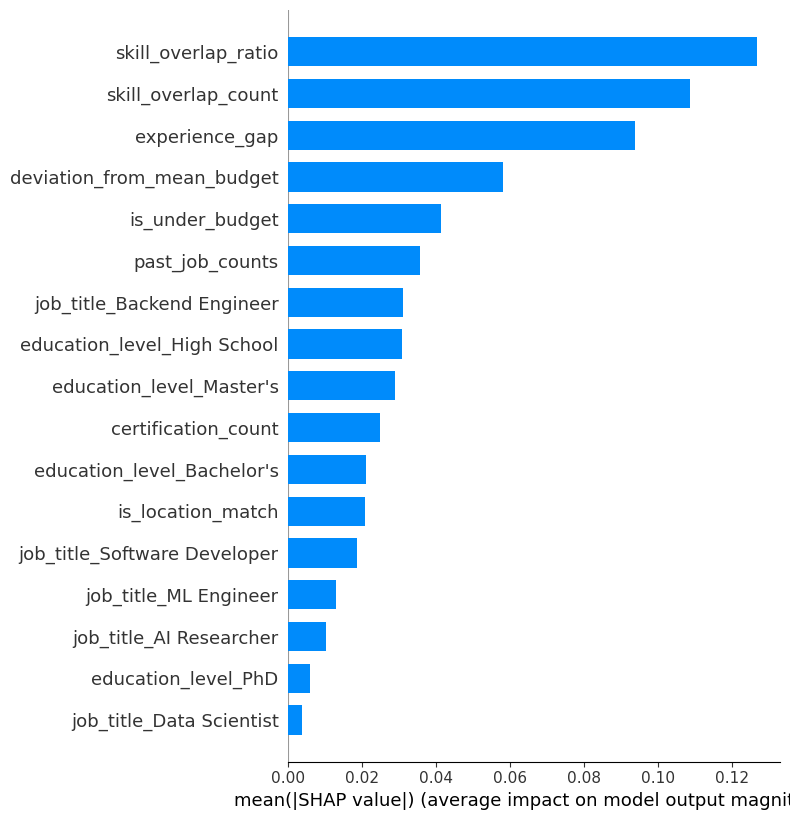

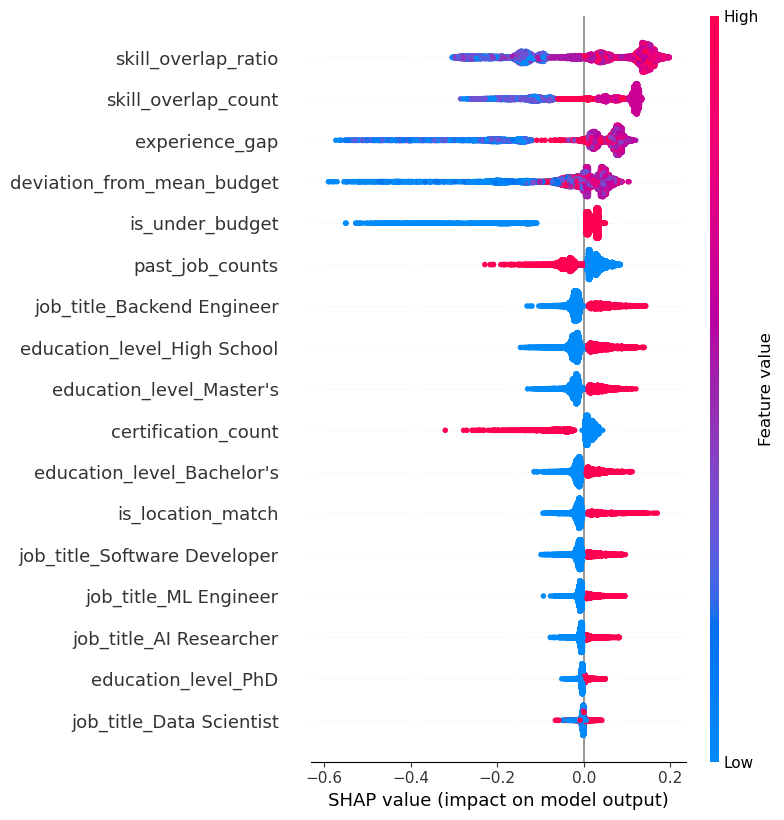

In [251]:
# Fit SHAP explainer
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_train_smote)

# Select SHAP values for class 1 (is fit)
shap_values_pos = shap_values_rf[:, :, 1]  

# Plot SHAP summary plots for the positive class
shap.summary_plot(shap_values_pos, X_train_smote, plot_type="bar")
shap.summary_plot(shap_values_pos, X_train_smote)

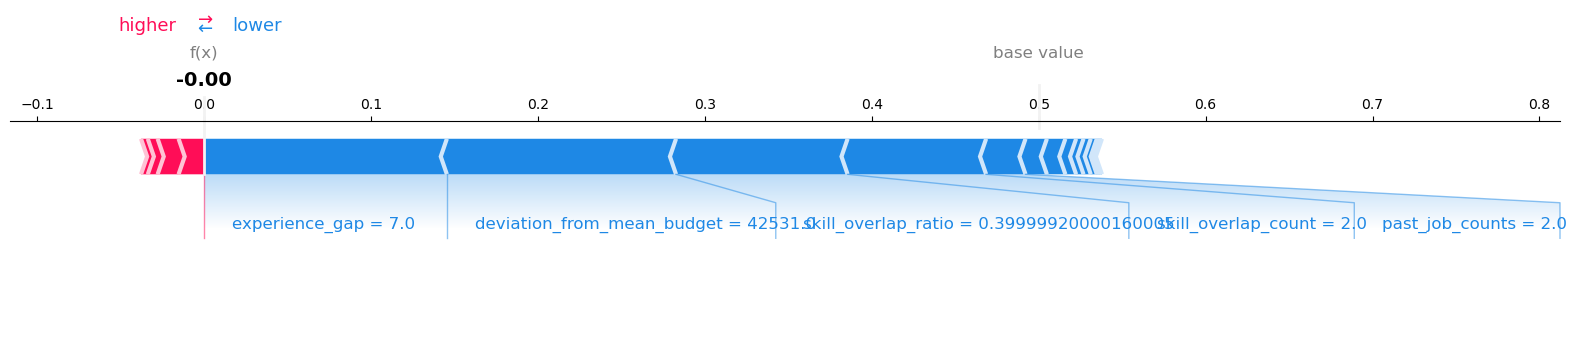

In [252]:
# Pick an index (e.g., first sample in test set)
idx = 0

# RandomForest
shap.force_plot(
    explainer_rf.expected_value[1],
    shap_values_pos[idx],
    X_test.iloc[idx],
    matplotlib=True,
    show=True
)

## XGBoost classifier with weighted output

In [253]:
# Calculating ratio for weighted output.
ratio = Y_train.value_counts()[0] / Y_train.value_counts()[1]
scale_pos_weight = ratio  

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb_clf.fit(X_train, Y_train)

# Results of XGBoost classifier
y_pred = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)[:,1]

print(classification_report(Y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(Y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))

              precision    recall  f1-score   support

           0     0.9915    0.9677    0.9795       961
           1     0.5000    0.7949    0.6139        39

    accuracy                         0.9610      1000
   macro avg     0.7457    0.8813    0.7967      1000
weighted avg     0.9723    0.9610    0.9652      1000

ROC AUC: 0.9808159235838736
Confusion Matrix:
 [[930  31]
 [  8  31]]


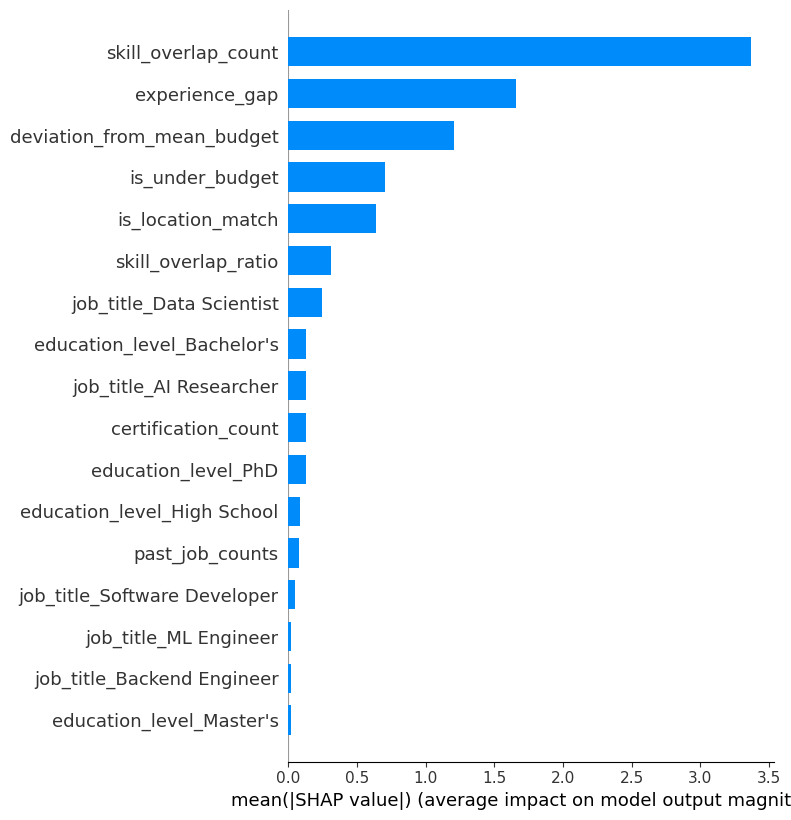

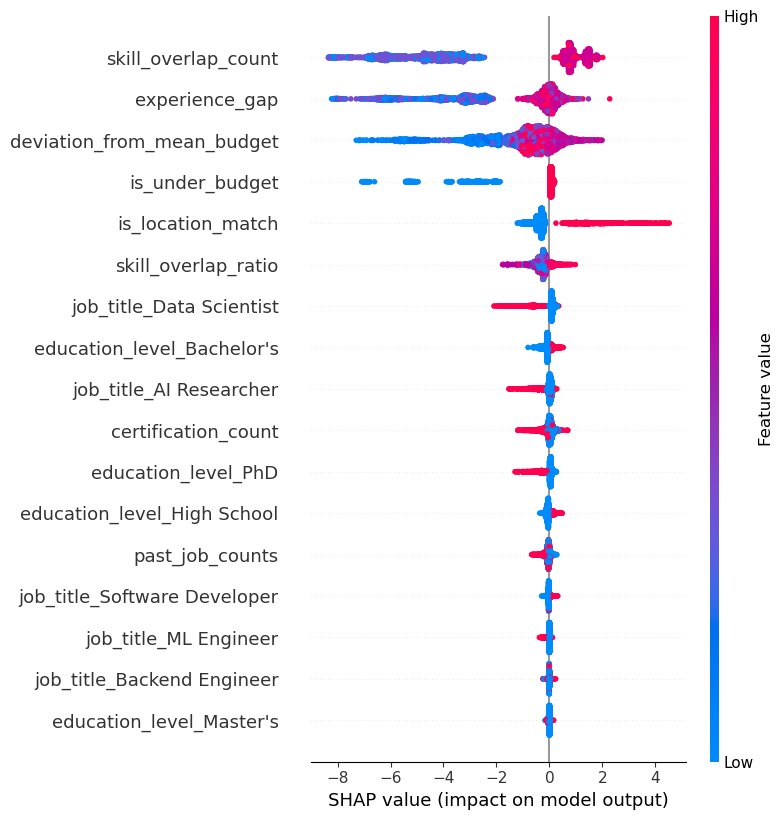

In [254]:
# Fit SHAP explainer
explainer_xgb = shap.TreeExplainer(xgb_clf)
shap_values_xgb = explainer_xgb.shap_values(X_train) 

# SHAP summary plots
shap.summary_plot(shap_values_xgb, X_train, plot_type="bar")
shap.summary_plot(shap_values_xgb, X_train)

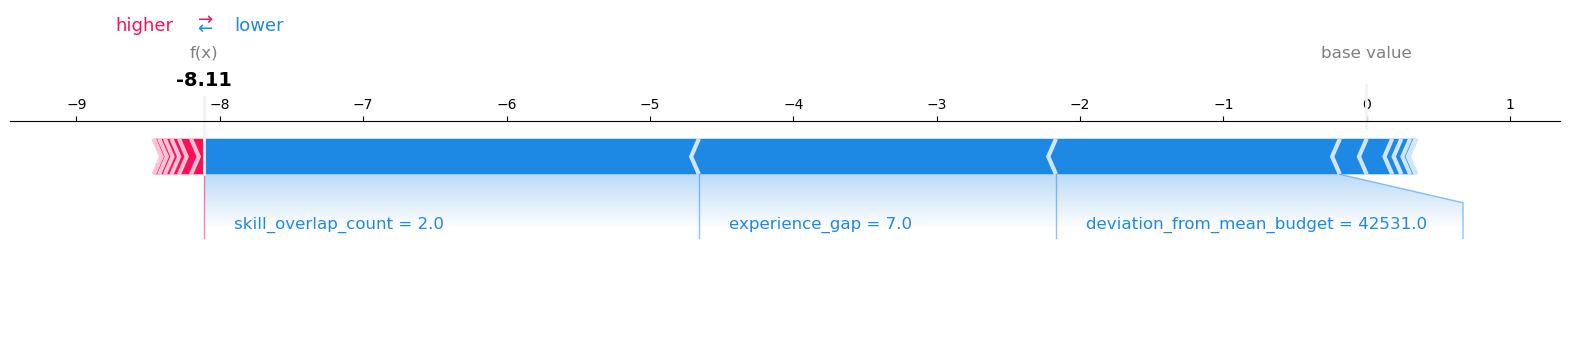

In [255]:
# Pick an index (e.g., first sample in test set)
idx = 0

# XGBoost
shap.force_plot(
    explainer_xgb.expected_value,
    shap_values_xgb[idx],
    X_test.iloc[idx],
    matplotlib=True,
    show=True
)
